In [1]:
!pip install -e ~/Documents/Cata2Data

Obtaining file:///home/micah/Documents/Cata2Data
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for cata2data (pyproject.toml) ... done
  Created wheel for cata2data: filename=cata2data-0.1.dev20+gea16918.d20230213-0.editable-py3-none-any.whl size=3385 sha256=8bb1e0867423de47edfb8792a9a0efce2bf69065e41cc5dd38c16ec2ef6d8dae
  Stored in directory: /tmp/pip-ephem-wheel-cache-sn_gzcys/wheels/2e/f3/d9/8cdd283e8200a92bc11bbe4919508fac2271fb524a4603af92
Successfully built cata2data
  Attempting uninstall: cata2data
    Found existing installation: cata2data 0.1.dev18+ge5c5207.d20230213
    Uninstalling cata2data-0.1.dev18+ge5c5207.d20230213:
      Successfully uninstalled cata2data-0.1.dev18+ge5c5207.d20230213


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm

# Read In Cosmos Image

In [3]:
from torch.utils.data import DataLoader
import numpy as np

from cata2data import CataData
from cata2data.preprocessing import (
    image_preprocessing,
    wcs_preprocessing,
    catalogue_preprocessing,
)

catalogue_paths = [
    "data/MIGHTEE_Continuum_Early_Science_COSMOS_Level1.fits",
    "data/MIGHTEE_Continuum_Early_Science_XMMLSS_Level1.fits",
]
image_paths = [
    "data/MIGHTEE_Continuum_Early_Science_COSMOS_r-1p2.app.restored.circ.fits",
    "data/MIGHTEE_Continuum_Early_Science_XMMLSS_r-1p2_circ.hires.fits",
]
field_names = ["COSMOS", "XMMLSS"]

### Create Data Set ###
mightee_data = CataData(
    catalogue_paths=catalogue_paths,
    image_paths=image_paths,
    field_names=field_names,
    cutout_width=70,
    catalogue_preprocessing=catalogue_preprocessing,
    image_preprocessing=image_preprocessing,
)

print(len(mightee_data))
train_dataloader = DataLoader(mightee_data, batch_size=64, shuffle=True)

1712


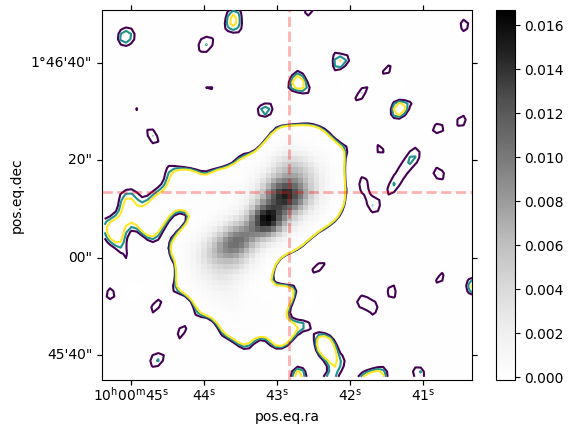

,NAME,RA,E_RA,DEC,E_DEC,S_INT,E_S_INT,S_PEAK,E_S_PEAK,NU_EFF,...,THETA_MAJ,E_THETA_MAJ,THETA_MIN,E_THETA_MIN,RESOLVED,ISL_RMS,GAUS_ID,SRC_ID,ISL_ID,field
4,J100042.86+014612.9,150.178604,0.0,1.77027,0.0,0.034663,0.000017,0.022838,0.000007,1.352688e+09,...,0.00197,0.0,0.00145,0.0,1,0.000007,4192,3509,3927,COSMOS


In [4]:
idx = 4
mightee_data.plot(idx)
mightee_data.df.iloc[idx : idx + 1]

In [5]:
mightee_data.wcs

{'COSMOS': WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---SIN'  'DEC--SIN'  
 CRVAL : 150.11916666667  2.205833333333302  
 CRPIX : 2726.0  2726.0  
 PC1_1 PC1_2  : 1.0  0.0  
 PC2_1 PC2_2  : 0.0  1.0  
 CDELT : -0.00030555555555556  0.00030555555555556  
 NAXIS : 5450  5450  1  1,
 'XMMLSS': WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN'  'DEC--TAN'  
 CRVAL : 35.15223662  -4.833701903  
 CRPIX : 4601.5  2352.0  
 NAXIS : 9203  4706}

/tmp/ipykernel_72613/134762504.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(projection=wcs)


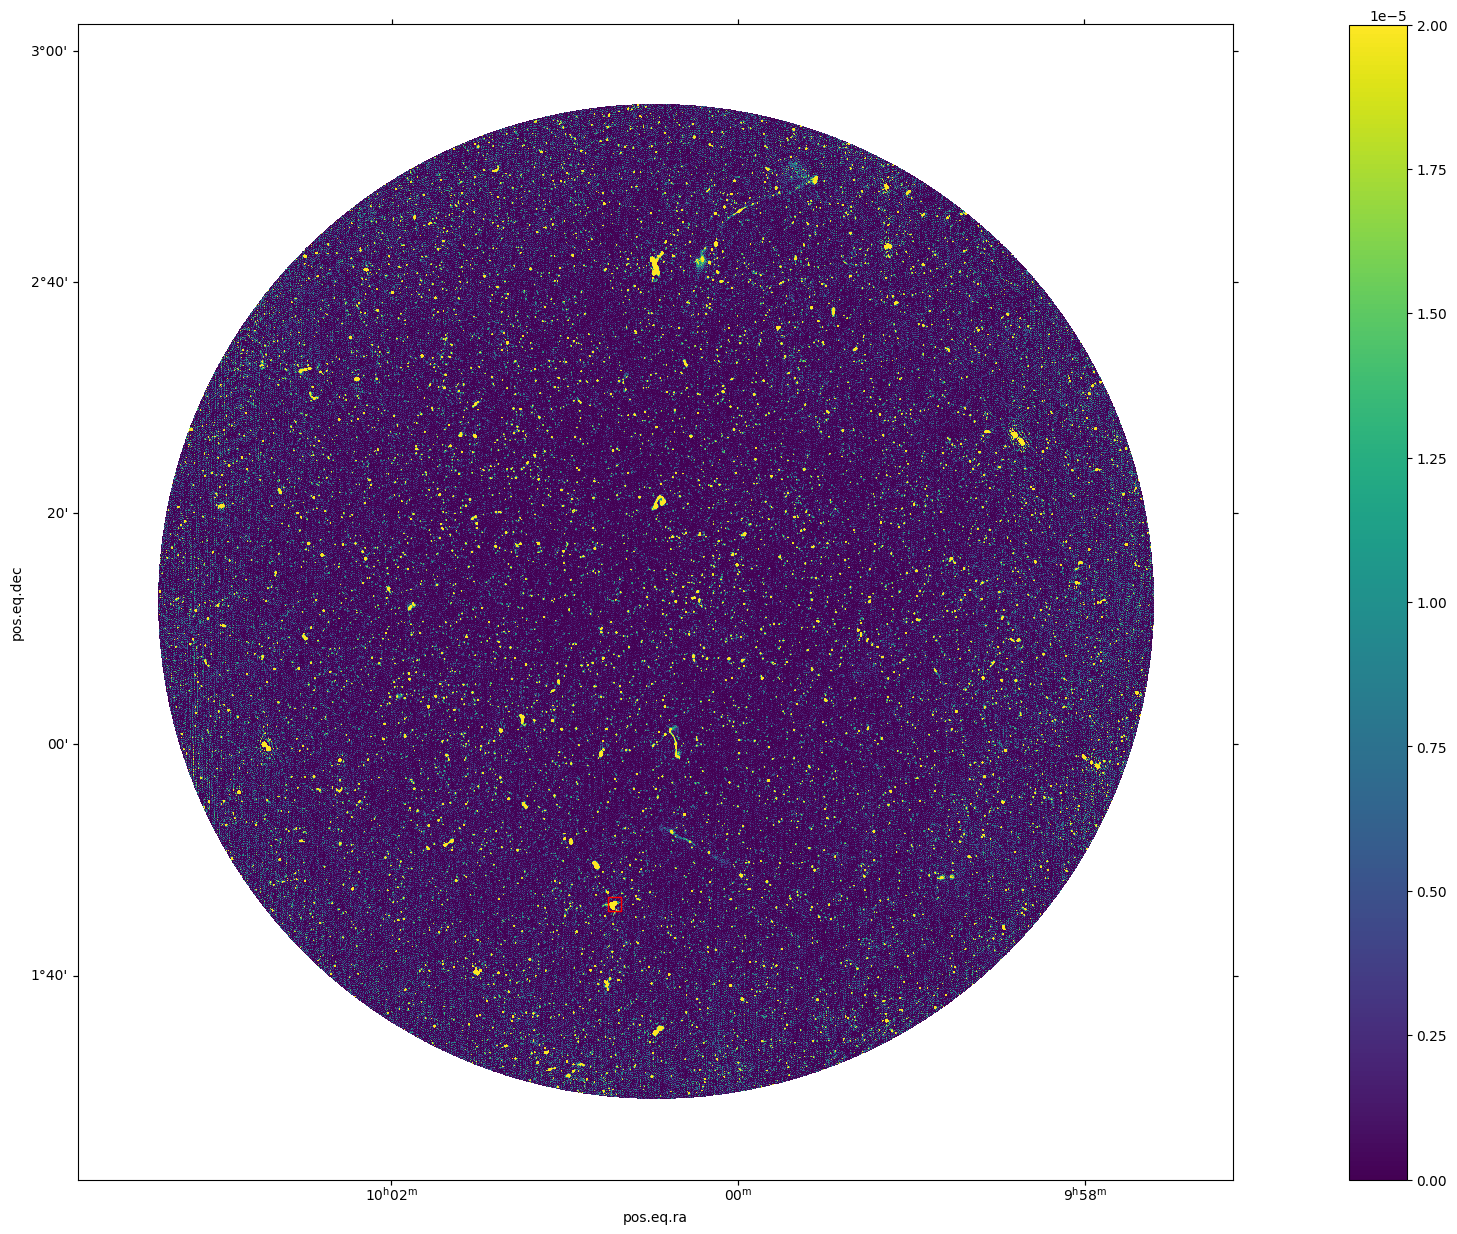

In [6]:
## Demonstration of box plotting
# Could loop over something like: mightee_data.df[mightee_data.df["field"]=="XMMLSS"].index
from astropy.nddata import Cutout2D

origin = 0
cutout_size = 64
entry = mightee_data.df.iloc[idx]
wcs = mightee_data.wcs[entry.field]

positions = wcs.all_world2pix(
    entry[["RA", "DEC"]].values[np.newaxis, :].astype(np.float64), origin
)
image = mightee_data.images[entry.field]
cutout = Cutout2D(
    mightee_data.images[entry.field], positions[0], (cutout_size, cutout_size), wcs=wcs
)
fig = plt.subplots(figsize=(30, 15))
ax = plt.subplot(projection=wcs)
img = ax.imshow(np.squeeze(image), origin="lower", vmin=0.0, vmax=2.0e-5)
plt.colorbar(img)
cutout.plot_on_original(color="red")
plt.show()

# Read in Cosmos Catalogue

In [7]:
catalogue = "data/MIGHTEE_Continuum_Early_Science_COSMOS_Level1.fits"
with fits.open(catalogue, memmap=True) as hdul_cat:
    hdul_cat.info()
    df = pd.DataFrame(hdul_cat[1].data)
df.head()

Filename: data/MIGHTEE_Continuum_Early_Science_COSMOS_Level1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      11   ()      
  1                1 BinTableHDU     95   9896R x 29C   [19A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, E, J, J, J]   


,NAME,RA,E_RA,DEC,E_DEC,S_INT,E_S_INT,S_PEAK,E_S_PEAK,NU_EFF,...,E_IM_PA,THETA_MAJ,E_THETA_MAJ,THETA_MIN,E_THETA_MIN,RESOLVED,ISL_RMS,GAUS_ID,SRC_ID,ISL_ID
0,J100320.73+020931.7,150.836411,0.00029,2.15882,0.00030,0.000104,0.000029,0.000056,0.000011,1.304066e+09,...,25.103121,0.00317,0.00109,0.00124,0.00098,0,0.000010,0,0,0
1,J100320.26+021312.7,150.834427,0.00003,2.22022,0.00008,0.000370,0.000024,0.000248,0.000010,1.304925e+09,...,4.725640,0.00274,0.00023,0.00000,0.00000,1,0.000010,1,1,1
2,J100319.37+021447.2,150.830734,0.00011,2.24645,0.00013,0.000075,0.000016,0.000079,0.000009,1.305699e+09,...,50.223122,0.00057,0.00135,0.00000,0.00000,0,0.000010,2,3,2
3,J100318.49+021000.5,150.827057,0.00016,2.16682,0.00021,0.000061,0.000018,0.000058,0.000010,1.306541e+09,...,31.520969,0.00138,0.00106,0.00000,0.00000,0,0.000010,3,4,3
4,J100317.73+021606.7,150.823883,0.00007,2.26855,0.00008,0.000164,0.000019,0.000142,0.000010,1.306922e+09,...,89.285698,0.00104,0.00045,0.00082,0.00053,0,0.000009,4,5,4


In [8]:
# Only consider resolved sources
df = df.loc[df["RESOLVED"] == 1]

# Sort by S_INT (integrated flux)
df = df.sort_values("S_PEAK", ascending=False, ignore_index=True).reset_index(drop=True)

# Only consider unique islands of sources
# df = df.groupby("ISL_ID", as_index=True).first()
df = df.drop_duplicates(subset=["ISL_ID"], keep="first")

# Only keep relevant columns
# df = df[["RA", "DEC", "S_INT", "S_PEAK", "IM_MAJ", "IM_MIN", "IM_PA", "THETA_MAJ", "ISL_RMS"]]

# Quick peak
df.head()

,NAME,RA,E_RA,DEC,E_DEC,S_INT,E_S_INT,S_PEAK,E_S_PEAK,NU_EFF,...,E_IM_PA,THETA_MAJ,E_THETA_MAJ,THETA_MIN,E_THETA_MIN,RESOLVED,ISL_RMS,GAUS_ID,SRC_ID,ISL_ID
0,J095821.54+022600.0,149.589783,0.0,2.43335,0.0,0.038022,0.000015,0.037699,0.000009,1.333992e+09,...,1.93664,0.00028,0.0,0.00014,0.00001,1,0.000009,9296,7674,8680
1,J095825.06+022650.0,149.604446,0.0,2.44723,0.0,0.027454,0.000016,0.026021,0.000009,1.335211e+09,...,0.36079,0.00075,0.0,0.00029,0.00001,1,0.000009,9303,7674,8681
2,J100217.96+015836.1,150.574860,0.0,1.97671,0.0,0.026073,0.000012,0.025939,0.000007,1.343968e+09,...,0.76808,0.00033,0.0,0.00000,0.00000,1,0.000007,798,698,742
3,J095908.30+024309.5,149.784622,0.0,2.71932,0.0,0.025080,0.000016,0.024726,0.000009,1.327427e+09,...,0.65349,0.00046,0.0,0.00000,0.00000,1,0.000009,8121,6682,7565
4,J100242.56+015938.5,150.677368,0.0,1.99404,0.0,0.022369,0.000014,0.024356,0.000009,1.330282e+09,...,0.12601,0.00044,0.0,0.00000,0.00000,1,0.000009,309,277,296


In [9]:
image_path = "data/MIGHTEE_Continuum_Early_Science_COSMOS_r-1p2.app.restored.circ.fits"
with fits.open(image_path, memmap=True) as hdul:
    hdul.info()
    image = hdul[0].data

Filename: data/MIGHTEE_Continuum_Early_Science_COSMOS_r-1p2.app.restored.circ.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5450, 5450, 1, 1)   float32   


/tmp/ipykernel_72613/1816158029.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(projection=wcs)


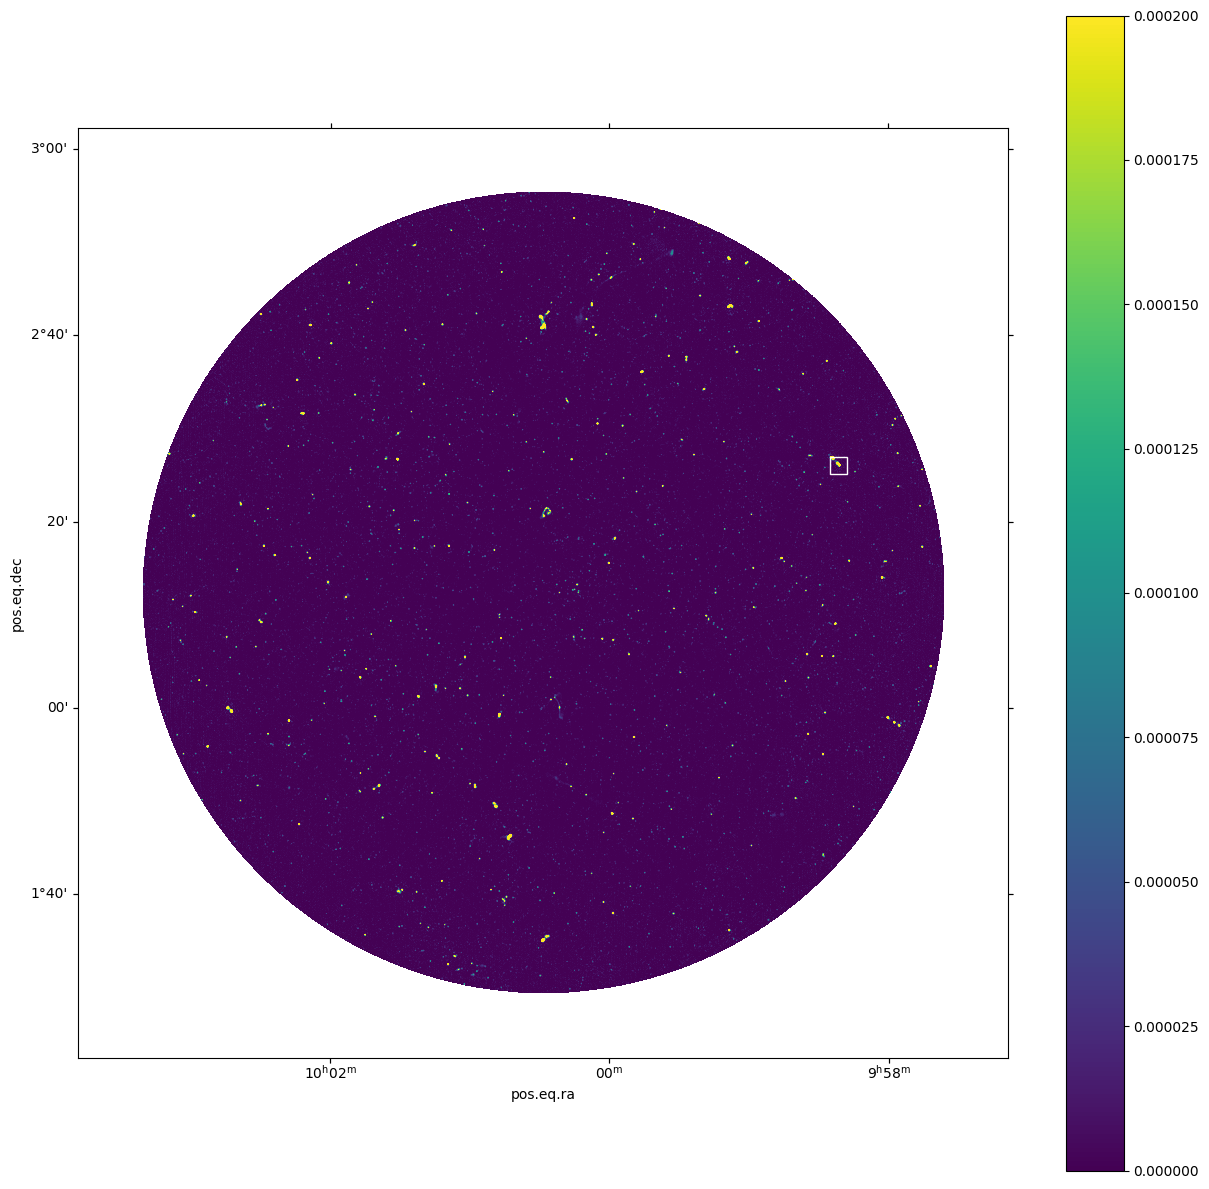

In [10]:
# Test astropy cutout
from astropy.nddata import Cutout2D

coords = df[["RA", "DEC"]].values
coords.shape
wcs = (
    WCS(hdul[0].header).dropaxis(3).dropaxis(2)
)  # Remove spurious axis (one of which is freq but mfs, one is polarisation stokes I).
origin = 0
positions = wcs.all_world2pix(coords, origin)
cutout = Cutout2D(np.squeeze(image), positions[0], (100, 100), wcs=wcs)
fig = plt.subplots(figsize=(15, 15))
ax = plt.subplot(projection=wcs)
img = ax.imshow(np.squeeze(image), origin="lower", vmin=0.0, vmax=2.0e-4)
plt.colorbar(img)
cutout.plot_on_original(color="white")
plt.show()